In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.cluster import rand_score
from sklearn import preprocessing
import seaborn as sns 
from sklearn.metrics import confusion_matrix
import gower
from sklearn.metrics import silhouette_samples, silhouette_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, auc, roc_curve
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform
seed= 15100873

## Data Importation and processing 

In [2]:
df=pd.read_csv(r'kickstarter_data(category_cleaned).csv')
df["goal"]=np.log(df["goal"])
df['pledged']= np.log(df["pledged"])
def get_day(i):
    return int(i.split()[0])
get_Day_vect = np.vectorize(get_day)
df["deadline_to_launch"]=get_Day_vect(df["deadline_to_launch"])
df=df[(df["state"]=='canceled')^(df["state"]=='failed')^(df["state"]=='successful') ]

c:\Users\buzga\anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


## PCA
- To start off we are just going to look at numeric features 

the primary two princple account for 42.41261808588644% and 23.723291067180053% of varaince
we can see that these two princple compoents strongly corespond to name_len and usd_pledged


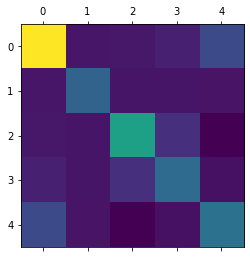

In [3]:
df_max_scaled = df.copy()
# apply normalization techniques on Column 1
cols=[ 'name_len','usd_pledged','deadline_to_launch', 'goal' , 'blurb_len']
for col in cols:
    df_max_scaled[col] = df_max_scaled[col] /df_max_scaled[col].abs().max()
X=df_max_scaled[cols]
pca = PCA(n_components=2)
pca.fit(X)
print("the primary two princple account for {0}% and {1}% of varaince".format(pca.explained_variance_ratio_[0]*100,pca.explained_variance_ratio_[1]*100 ))
plt.matshow(pca.get_covariance())
print("we can see that these two princple compoents strongly corespond to name_len and usd_pledged")




Text(0, 0.5, 'principle component two')

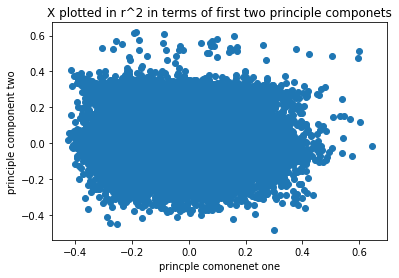

In [4]:
X_tansform=pca.transform(X)
# X_tansform[:,1]=np.log(X_tansform[:,1])
plt.scatter(*X_tansform.T)
plt.title("X plotted in r^2 in terms of first two principle componets")
plt.xlabel("princple comonenet one")
plt.ylabel("principle component two") 

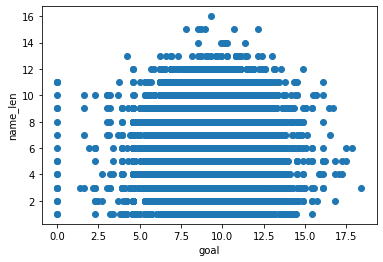

In [5]:
fig, ax = plt.subplots()
scatter = ax.scatter(df['goal'], df['name_len'])
ax.set_xlabel('goal')
ax.set_ylabel('name_len')
plt.show()

- As can be seen for the above corelation matrix USD Plegged and Name lenght seem to account for the majority of numeric variance but as name length is discrete interpreation is hard. 
- we can also run a PCA with all varibles, 

the primary two princple account for 41.491762253646655% and 15.016002256013278% of varaince
we can see that these two princple compoents strungly correspont to is_staff_pick and is_staff_pick


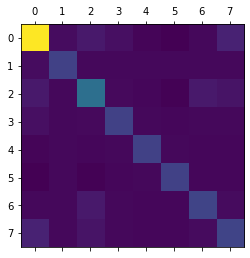

In [6]:
df_max_scaled = df.copy()
# apply normalization techniques on Column 1
column = 'Column 1'
cols=['is_staff_pick', 'usd_pledged','name_len', 'goal','deadline_to_launch','country_id', 'blurb_len', 'category_id' ]
for col in cols:
    df_max_scaled[col] = df_max_scaled[col] /df_max_scaled[col].abs().max()
X=df_max_scaled[cols]
pca = PCA(n_components=2)
pca.fit(X)
print("the primary two princple account for {0}% and {1}% of varaince".format(pca.explained_variance_ratio_[0]*100,pca.explained_variance_ratio_[1]*100 ))
## i think it is goal and deadline 
plt.matshow(pca.get_covariance())
print("we can see that these two princple compoents strungly correspont to is_staff_pick and is_staff_pick")




Text(0, 0.5, 'principle component two')

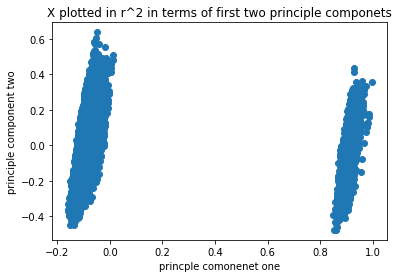

In [7]:
X_tansform=pca.transform(X)
plt.scatter(*X_tansform.T)
plt.title("X plotted in r^2 in terms of first two principle componets")
plt.xlabel("princple comonenet one")
plt.ylabel("principle component two") 

- but this yields a catagorical vairble as one of the principle componetnts which is also not interpretable. 
- so we are going to try to continue this project with out Dimensionality reduction. 

### Classfication Models. 

- functions for evaluation 

In [8]:
def generate_confusion_matix(model, X_test, y_test, model_name):
    y_pred=model.predict(X_test)
    conf_matrix=confusion_matrix(y_test, y_pred)
    disp=ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=[0,1])
    disp.plot()
    plt.grid()
    plt.title(model_name+" confusion matrix")
    plt.show()
def generate_percsion_recall_curve(model, x, y):
    y_scores=model.predict_proba(x)[:,1] ## probability of predicting postive clas s. 
    precision, recall, thresholds = precision_recall_curve(y, y_scores)
    plt.figure(figsize=(12, 8))
    plt.plot(recall, precision, color="purple")
    neg=df['SuccessfulBool'].value_counts(ascending = True).iloc[0]
    pos=df['SuccessfulBool'].value_counts(ascending = True).iloc[1]
    plt.axhline(y=pos/(pos+neg), color='r', linestyle='--')
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(str(model)+" Precision-Recall Curve")
    plt.show()
def generate_percsion_ROC_curve(model, x, y, model_name ):
    y_scores=model.predict_proba(x)[:,1]
    fpr, tpr, thresholds = roc_curve(y, y_scores)
    y_pred=model.predict(x)
    
    random_classifier=np.linspace(0.0, 1.0, 100)
    plt.figure(figsize=(12, 8))
    plt.plot(fpr, tpr, color="purple")
    plt.plot(random_classifier, random_classifier, 'r--')
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title(model_name+" ROC Curve")
    plt.show()
    print("average model accuracy is {0}%".format(model.score(x,y))) ## which seems sussy. 
    print("recall", recall_score(y, y_pred))
    print("precision", precision_score(y, y_pred))
    print("f1", f1_score(y, y_pred))
    print("Area under ROC Curve (AUROC): ", auc(fpr, tpr))

train test split 

In [9]:
y=df["SuccessfulBool"]
X=df[['goal','country_id','name_len','blurb_len', 'deadline_to_launch','category_id','is_staff_pick']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
X_mode=df[['goal','country_id','name_len','blurb_len', 'deadline_to_launch(by second)','category_id','is_staff_pick']]
X_train_mode, X_test_mode, y_train_mode, y_test_mode = train_test_split(X_mode, y, test_size=0.2, random_state=seed)

hyper parameters tuneing 

In [10]:
gbc = GradientBoostingClassifier()
parameters = {
        "n_estimators": [1, 2, 5, 10, 20, 50, 100, 200, 500],
    "max_leaf_nodes": [2, 5, 10, 20, 50, 100],
    "learning_rate": loguniform(0.01, 1),
'min_samples_leaf': range (10,50,10), 
'max_depth': range(2,10,1),
'random_state':[seed]

}
grad_boost_model = GradientBoostingClassifier()
search_cv = RandomizedSearchCV(grad_boost_model, parameters, scoring='roc_auc',n_iter=10, random_state=0, n_jobs=2)
search_cv.fit(X_train, y_train)
columns = [f"param_{name}" for name in parameters.keys()]
columns += ["mean_test_error", "std_test_error"]
cv_results = pd.DataFrame(search_cv.cv_results_)
cv_results["mean_test_error"] = -cv_results["mean_test_score"]
cv_results["std_test_error"] = cv_results["std_test_score"]
cv_results[columns].sort_values(by="mean_test_error")


,param_n_estimators,param_max_leaf_nodes,param_learning_rate,param_min_samples_leaf,param_max_depth,param_random_state,mean_test_error,std_test_error
1,20,100,0.494884,30,5,15100873,-0.832059,0.005130
6,10,100,0.396568,40,5,15100873,-0.827631,0.006383
3,50,2,0.383222,20,9,15100873,-0.822079,0.005603
8,5,20,0.110585,30,6,15100873,-0.814648,0.010922
4,10,5,0.470065,10,2,15100873,-0.814271,0.004745
9,20,2,0.081715,10,4,15100873,-0.779916,0.007971
0,10,2,0.125207,40,7,15100873,-0.774900,0.005996
5,10,2,0.054511,30,7,15100873,-0.728833,0.009577
7,1,5,0.01724,20,2,15100873,-0.716851,0.006450
2,2,2,0.039361,10,2,15100873,-0.603010,0.004877


model fitting 

In [11]:
rf_mdoel=RandomForestClassifier(max_depth=2, random_state=seed).fit(X_train, y_train)
grad_boost_model = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=seed).fit(X_train, y_train)
params={  "n_estimators": 20,
    "max_leaf_nodes": 100,
    "learning_rate": 0.494884,
'min_samples_leaf': 30, 
'max_depth': 5,
'random_state':seed}
grad_boost_model = GradientBoostingClassifier(**params).fit(X_train, y_train)
logistic_model=LogisticRegression(random_state=seed).fit(X_train, y_train)
Mode_model=LogisticRegression(random_state=seed).fit(X_train_mode, y_train_mode)

algomartive clustering model 

Accuracy: 0.7555629359016938
Recall: 0.2442528735632184
Precision: 0.7302405498281787
F1_score: 0.36606373815676135


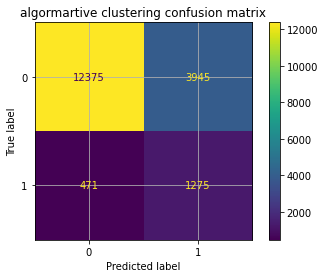

In [12]:
all_features=['goal','name_len',  'blurb_len', 'deadline_to_launch','is_staff_pick','country_id','category_id' ]
X=df[all_features]  
target=df[["SuccessfulBool"]]
distance_matrix = gower.gower_matrix(X) 
labels = pd.DataFrame()
labels['target'] = target.values.reshape(1, -1).tolist()[0]
model_complete = AgglomerativeClustering(n_clusters=2, linkage='complete', affinity='precomputed')
clusters_complete = model_complete.fit_predict(distance_matrix)
labels['complete-predictions'] = clusters_complete
cri = rand_score(target.values.reshape(1, -1)[0], clusters_complete)
labels.value_counts(["target", "complete-predictions"])
cf_matrix = confusion_matrix(target.values.reshape(1, -1)[0], labels[['complete-predictions']].values.reshape(1, -1)[0])
cf_labels = ['True Neg','False Pos','False Neg','True Pos']
cf_labels = np.asarray(cf_labels).reshape(2,2)
fpr, tpr, thresholds = roc_curve(target.values.reshape(1, -1)[0], labels[['complete-predictions']].values.reshape(1, -1)[0])
True_neg = cf_matrix[0,0]
False_pos = cf_matrix[0,1]
True_pos = cf_matrix[1,1]
False_neg = cf_matrix[1,0]
accuracy = (True_neg + True_pos)/(True_neg + False_neg + True_pos + False_pos)
recall = (True_pos)/(False_neg+True_pos)
precision = (True_pos)/(False_pos + True_pos)
F1_score = 2 * ((precision*recall)/(precision+recall))
print(f'Accuracy: {accuracy}')
print(f'Recall: {recall}')
print(f'Precision: {precision}')
print(f'F1_score: {F1_score}')
conf_matrix=confusion_matrix(labels[['complete-predictions']].values.reshape(1, -1)[0], target.values.reshape(1, -1)[0])
disp=ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=[0,1])
disp.plot()
plt.grid()
plt.title("algormartive clustering "+ "confusion matrix")
plt.show()

model evaluation 

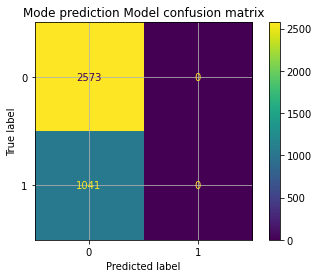

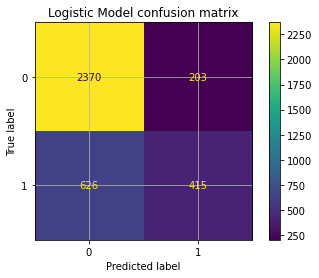

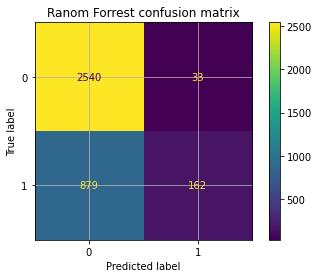

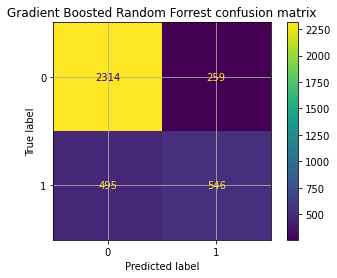

In [13]:
generate_confusion_matix(Mode_model, X_test_mode, y_test_mode,"Mode prediction Model" ) ## the logistic model always precits 0 that is it never predicts a sucessfull campaign 
generate_confusion_matix(logistic_model, X_test, y_test,"Logistic Model" ) ## the logistic model always precits 0 that is it never predicts a sucessfull campaign 
generate_confusion_matix(rf_mdoel, X_test, y_test,"Ranom Forrest" ) 
generate_confusion_matix(grad_boost_model, X_test, y_test,"Gradient Boosted Random Forrest") 

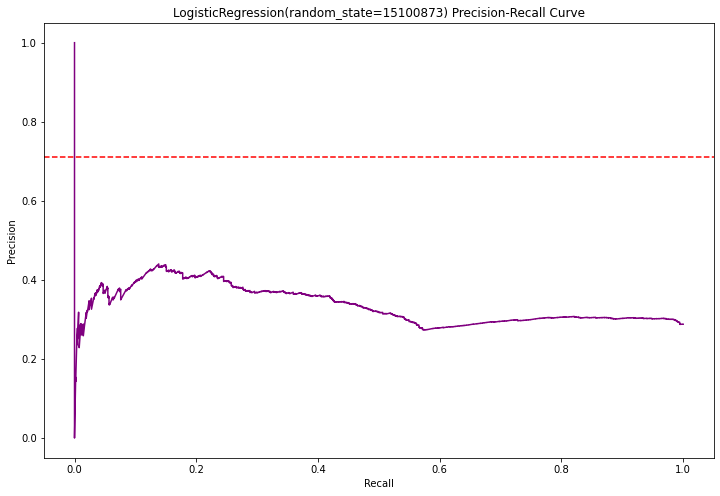

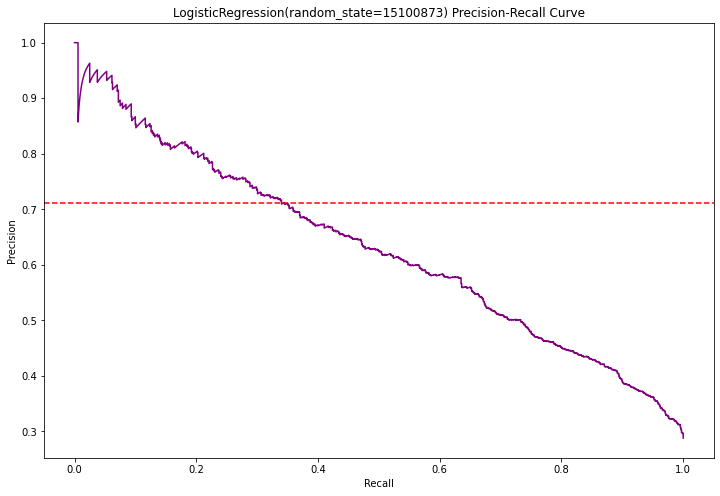

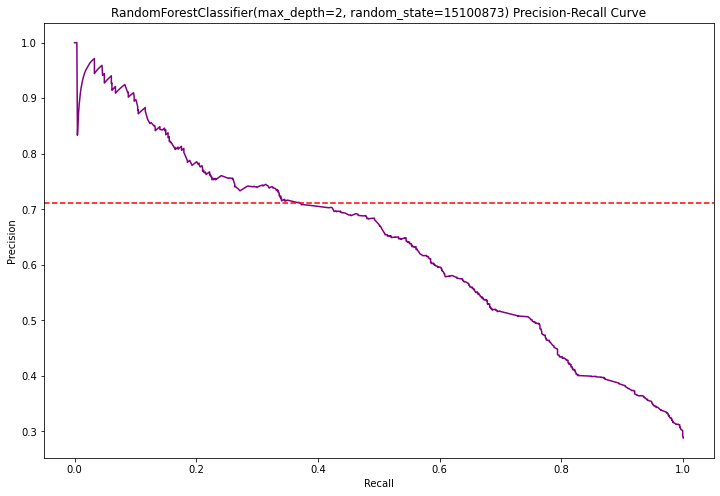

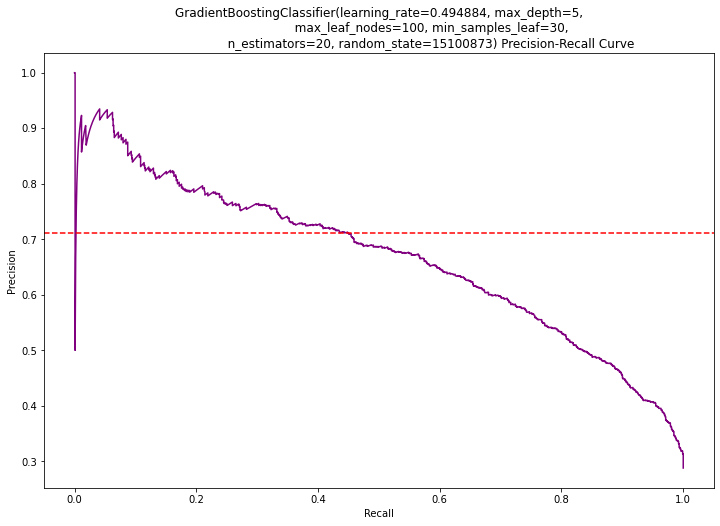

In [14]:
X_train_mode, X_test_mode, y_train_mode, y_test_mode = train_test_split(X_mode, y, test_size=0.2, random_state=seed)
Mode_model=LogisticRegression(random_state=seed).fit(X_train_mode, y_train_mode)
generate_percsion_recall_curve(Mode_model, X_test_mode, y_test_mode) 
generate_percsion_recall_curve(logistic_model, X_test, y_test) 
generate_percsion_recall_curve(rf_mdoel, X_test, y_test) 
generate_percsion_recall_curve(grad_boost_model, X_test, y_test) 



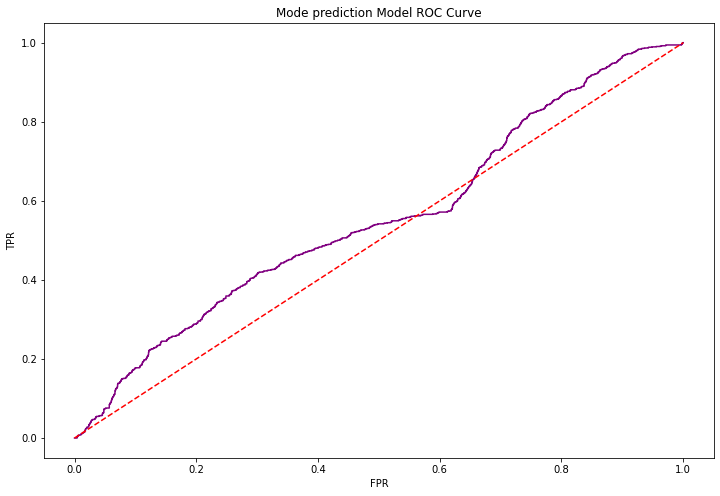

average model accuracy is 0.7119535141117875%
recall 0.0
precision 0.0
f1 0.0
Area under ROC Curve (AUROC):  0.5550665990166859


c:\Users\buzga\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


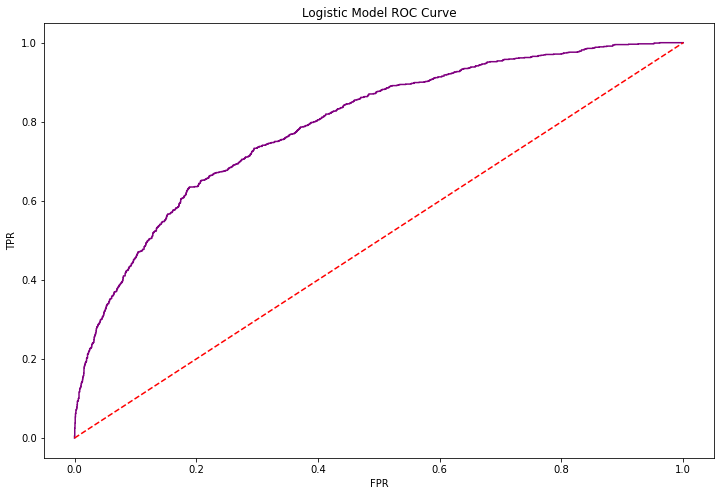

average model accuracy is 0.7706142778085224%
recall 0.39865513928914503
precision 0.6715210355987055
f1 0.5003013863773357
Area under ROC Curve (AUROC):  0.7925704864638436


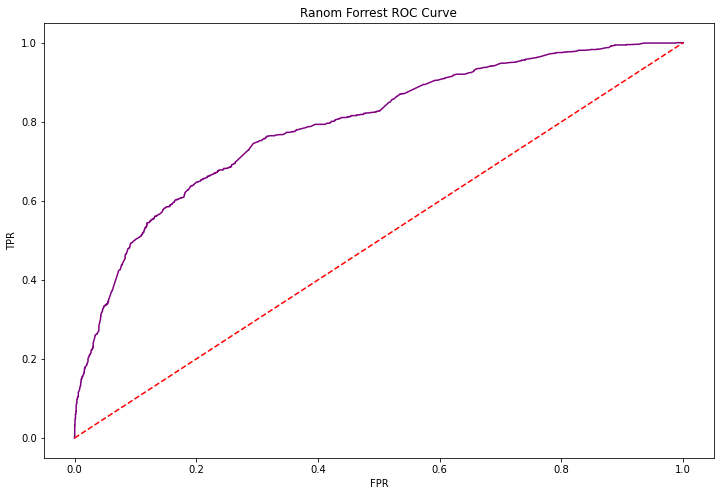

average model accuracy is 0.7476480354178195%
recall 0.15561959654178675
precision 0.8307692307692308
f1 0.26213592233009714
Area under ROC Curve (AUROC):  0.7912372740940522


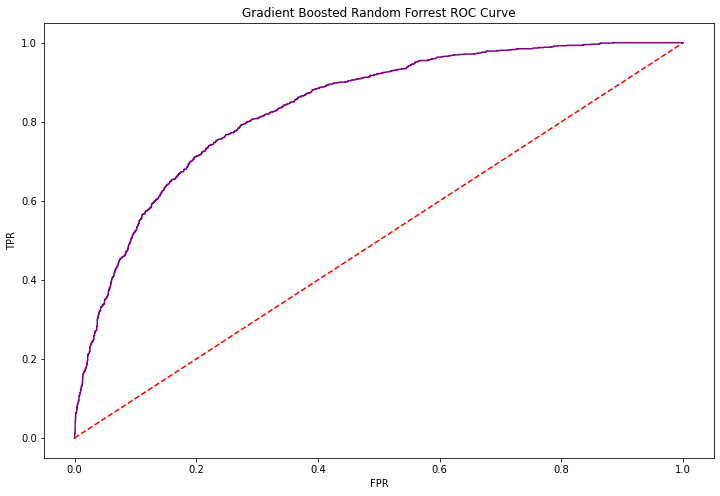

average model accuracy is 0.7913669064748201%
recall 0.5244956772334294
precision 0.6782608695652174
f1 0.5915492957746479
Area under ROC Curve (AUROC):  0.8366312698969158


In [15]:
generate_percsion_ROC_curve(Mode_model, X_test_mode, y_test_mode,"Mode prediction Model" ) ## the logistic model always precits 0 that is it never predicts a sucessfull campaign 
generate_percsion_ROC_curve(logistic_model, X_test, y_test,"Logistic Model" ) ## the logistic model always precits 0 that is it never predicts a sucessfull campaign 
generate_percsion_ROC_curve(rf_mdoel, X_test, y_test,"Ranom Forrest" ) 
generate_percsion_ROC_curve(grad_boost_model, X_test, y_test,"Gradient Boosted Random Forrest") 